In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pydataset import data
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")


import acquire
import telco_prep
import exploration

In [47]:
telco_df = acquire.get_telco_data()

telco_df.head()

,Unnamed: 0,internet_service_type_id,payment_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type
0,0,1,2,2,0002-ORFBO,Female,0,Yes,Yes,9,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,Mailed check,DSL
1,1,1,2,1,0003-MKNFE,Male,0,No,No,9,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,Mailed check,DSL
2,2,2,1,1,0004-TLHLJ,Male,0,No,No,4,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Electronic check,Fiber optic
3,3,2,1,1,0011-IGKFF,Male,1,Yes,No,13,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Electronic check,Fiber optic
4,4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Mailed check,Fiber optic


- Ran acquire function from SQL selecting all rows and columns
- Majority of the columns are categorical and have ability to be encoded 

In [3]:
telco_df.isna().sum()

telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   payment_type_id           7043 non-null   int64  
 3   contract_type_id          7043 non-null   int64  
 4   customer_id               7043 non-null   object 
 5   gender                    7043 non-null   object 
 6   senior_citizen            7043 non-null   int64  
 7   partner                   7043 non-null   object 
 8   dependents                7043 non-null   object 
 9   tenure                    7043 non-null   int64  
 10  phone_service             7043 non-null   object 
 11  multiple_lines            7043 non-null   object 
 12  online_security           7043 non-null   object 
 13  online_backup             7043 non-null   object 
 14  device_p

-- No nulls to fill
-- Total charges is an object which needs to change into float 

In [4]:
telco_df = telco_prep.prep_telco_data(telco_df)

telco_df.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges', 'churn',
       'contract_type', 'payment_type', 'internet_service_type', 'manual_pay',
       'manual_encoded', 'gender_encoded', 'partner_encoded',
       'dependents_encoded', 'phone_service_encoded',
       'paperless_billing_encoded', 'churn_encoded',
       'multiple_lines_No phone service', 'multiple_lines_Yes',
       'online_security_No internet service', 'online_security_Yes',
       'online_backup_No internet service', 'online_backup_Yes',
       'device_protection_No internet service', 'device_protection_Yes',
       'tech_support_No internet service', 'tech_support_Yes',
       'streaming_tv_No internet service', 'streaming_tv_Yes',
       'streaming_movies_No internet service', 'stream

In [5]:
telco_train, telco_validate, telco_test = telco_prep.split_telco(telco_df)

In [6]:
telco_train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_two,security_one,security_two,security_monthly,streaming_monthly,bundled_monthly,bundled_one,bundled_two,only_dsl,only_fiber
4216,Male,0,No,No,18,Yes,Yes,No,No,No,...,1,0,0,0,1,1,1,1,0,0
1477,Female,1,No,No,29,Yes,Yes,Yes,Yes,No,...,0,1,1,1,0,1,0,0,0,0
5752,Male,0,No,No,72,Yes,Yes,No internet service,No internet service,No internet service,...,0,0,0,0,0,0,0,0,0,0
1377,Male,0,Yes,Yes,65,Yes,Yes,No,Yes,Yes,...,1,1,1,1,1,0,0,1,0,0
3965,Female,0,Yes,Yes,58,Yes,No,Yes,Yes,No,...,1,1,1,1,1,1,1,1,0,0


In [7]:
telco_train.shape, telco_validate.shape, telco_test.shape

((4500, 69), (1125, 69), (1407, 69))

In [8]:
# In this section, I am looking to find the overall churn baseline so I can compare my models to the baseline
telco_train.churn.value_counts()

churn_baseline = 1196/4500

churn_baseline2 = 3304/4500

churn_baseline

churn_baseline2

# Using churn - yes the baseline is 27% and using churn - no the baseline 73%


0.7342222222222222

In [9]:
telco_train.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges', 'churn',
       'contract_type', 'payment_type', 'internet_service_type', 'manual_pay',
       'manual_encoded', 'gender_encoded', 'partner_encoded',
       'dependents_encoded', 'phone_service_encoded',
       'paperless_billing_encoded', 'churn_encoded',
       'multiple_lines_No phone service', 'multiple_lines_Yes',
       'online_security_No internet service', 'online_security_Yes',
       'online_backup_No internet service', 'online_backup_Yes',
       'device_protection_No internet service', 'device_protection_Yes',
       'tech_support_No internet service', 'tech_support_Yes',
       'streaming_tv_No internet service', 'streaming_tv_Yes',
       'streaming_movies_No internet service', 'stream

In [10]:
telco_train.security_suite_dsl.value_counts(), telco_train.security_suite_fiber.value_counts(),telco_train['internet_service_type_Fiber optic'].value_counts()



(1    2273
 0    2227
 Name: security_suite_dsl, dtype: int64,
 1    2284
 0    2216
 Name: security_suite_fiber, dtype: int64,
 0    2528
 1    1972
 Name: internet_service_type_Fiber optic, dtype: int64)

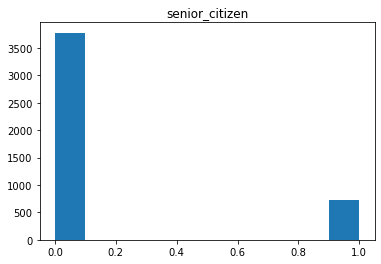

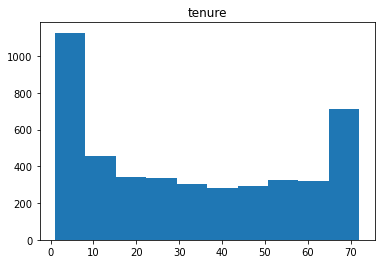

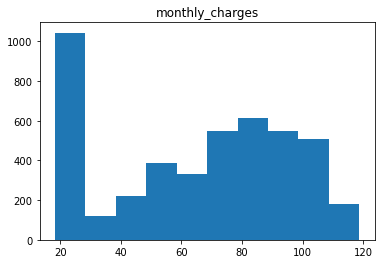

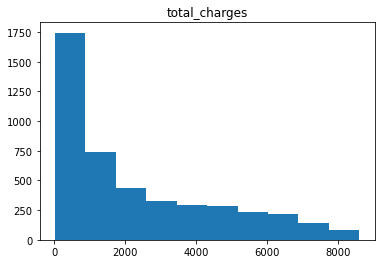

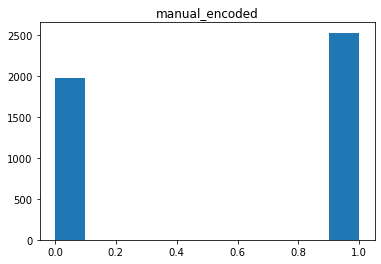

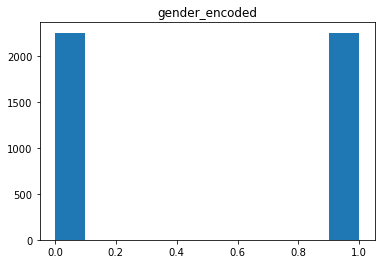

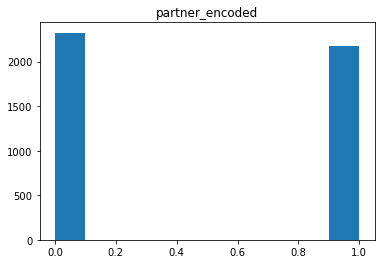

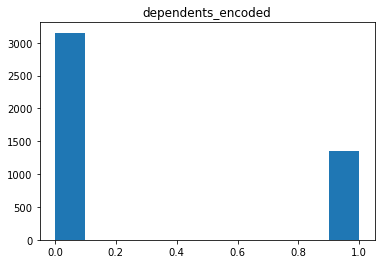

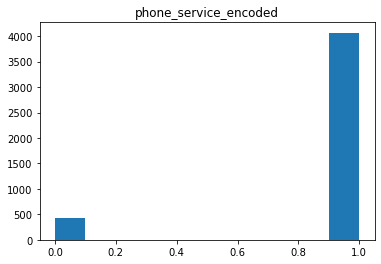

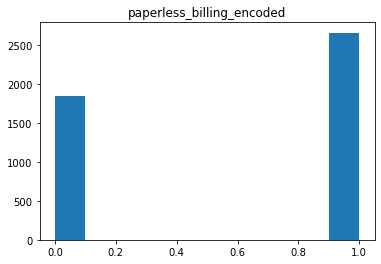

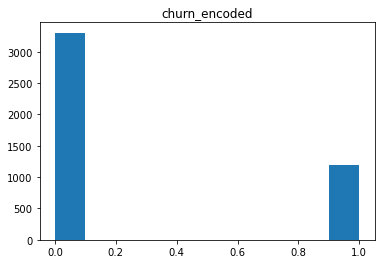

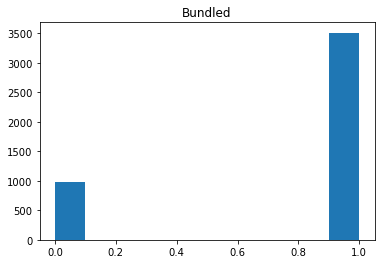

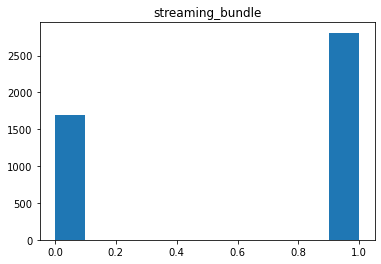

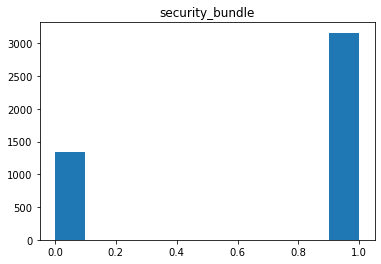

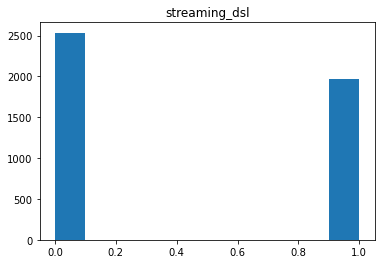

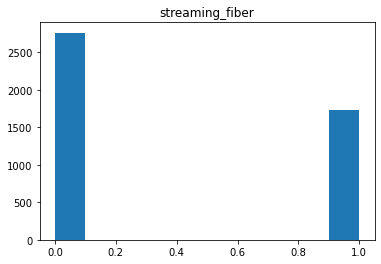

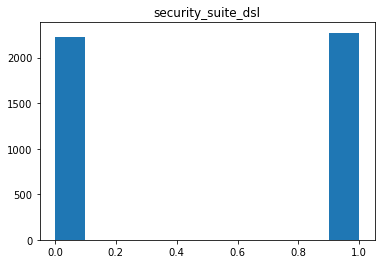

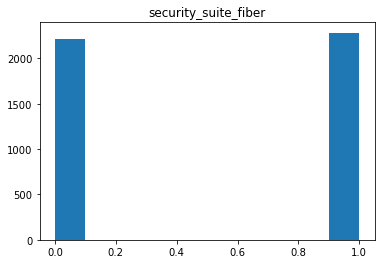

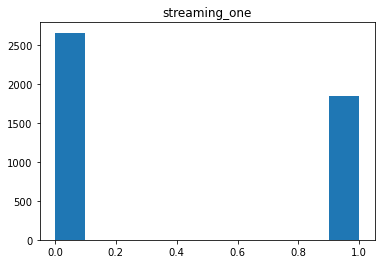

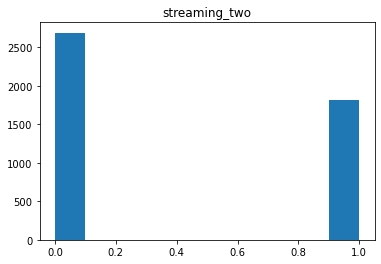

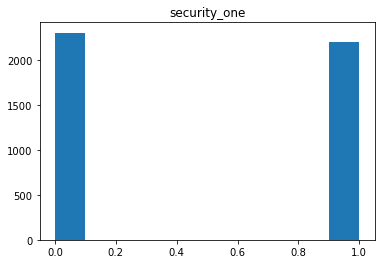

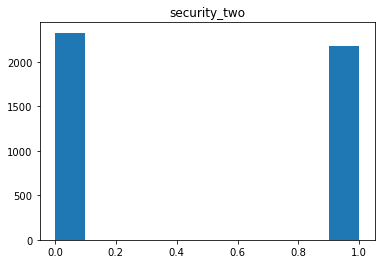

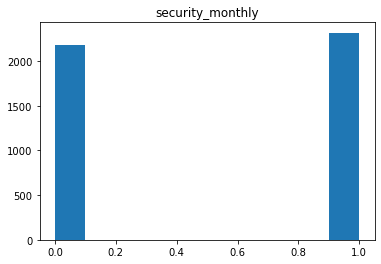

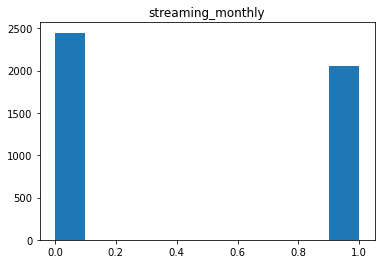

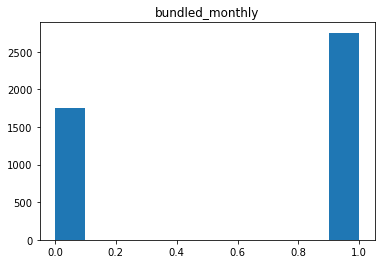

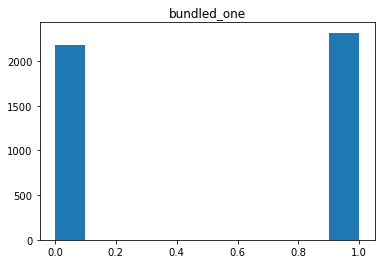

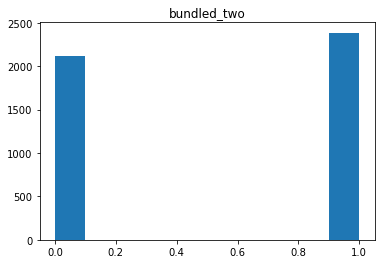

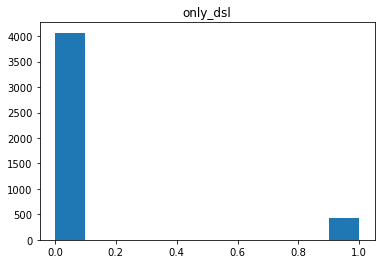

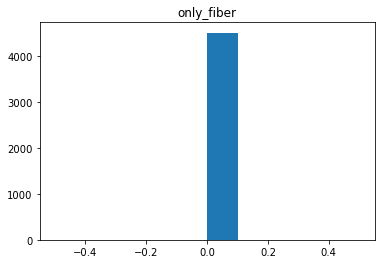

In [11]:
num_cols = telco_train.columns[[(telco_train[col].dtype == 'int64') or (telco_train[col].dtype == 'float64') for col in telco_train.columns]]
for col in num_cols:
    plt.hist(telco_train[col])
    plt.title(col)
    plt.show()
    # plt.boxplot(telco_train[col])
    # plt.title(col)
    # plt.show()

Looking at the tenure graph I wanted to see contract type vs churn to see if there was any correlation with contract type and churn

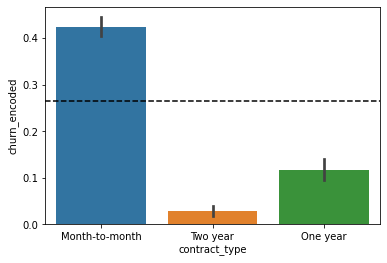

In [45]:
sns.barplot('contract_type', 'churn_encoded', data=telco_train)
plt.axhline(telco_train.churn_encoded.mean(), ls = '--', color = 'black')

Key Take aways -
	1. Senior citizens do not make up a significant portion of the data set
	2. Tenure shows that we are losing most of our customers in the first five months and slowly loses until month 40 where it starts to 	     creep back up
	3.  Aside from the initial spike in the 20-30 range it follows an almost  normal  distribution
	4. Total charges align with tenure with a swift drop from the beginning
	5. Manual encoded pay shows more people pay by check either electronic or mailed than automatic
	6. Gender and if customer has partner are equally split
	7. More people have no dependents
	8. Those with phone service far outweigh those without
	9. More people have paperless billing than not
	10. Churn encoded chart shows the baseline churn model
	11. More than triple the amount of people bundle their service with internet and phone
	12. About a 1000 more people include streaming services
	13. More than double the customers have security features 
	14. Only a handful of cusotmers have only dsl and no phone service
	15. Everyone with fiber has a bundle with phone service
	16. Month to month contracts turn are signicantly higher rate

In [48]:
contract_stat = pd.crosstab(telco_train.contract_type, telco_train.churn_encoded)

print(contract_stat)

a = 0.05

chi2, p, degf, expected = stats.chi2_contingency(contract_stat)

chi2, p


if p < a:
    print("We reject the null hypothesis and this variable is statistically significant")
else:
    print("We fail to reject the null hypothesis and this feature is not statisitcally significant")

churn_encoded      0     1
contract_type             
Month-to-month  1433  1058
One year         811   107
Two year        1060    31
We reject the null hypothesis and this variable is statistically significant


In [12]:
telco_train.describe()

,senior_citizen,tenure,monthly_charges,total_charges,manual_encoded,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,...,streaming_two,security_one,security_two,security_monthly,streaming_monthly,bundled_monthly,bundled_one,bundled_two,only_dsl,only_fiber
count,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,...,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.0
mean,0.160667,32.472889,64.725044,2289.320233,0.562000,0.500000,0.483556,0.299333,0.904000,0.589778,...,0.402444,0.488000,0.483333,0.514889,0.456000,0.611556,0.515111,0.530222,0.096000,0.0
std,0.367264,24.654959,30.209952,2270.394730,0.496196,0.500056,0.499785,0.458017,0.294624,0.491929,...,0.490445,0.499912,0.499778,0.499834,0.498116,0.487451,0.499827,0.499141,0.294624,0.0
min,0.000000,1.000000,18.250000,18.850000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,8.000000,34.775000,385.075000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,29.000000,70.200000,1400.575000,1.000000,0.500000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.0
75%,0.000000,56.000000,90.050000,3845.675000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.0
max,1.000000,72.000000,118.650000,8594.400000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [14]:
telco_train.info()

#telco_train.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500 entries, 4216 to 3374
Data columns (total 69 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   gender                                 4500 non-null   object  
 1   senior_citizen                         4500 non-null   int64   
 2   partner                                4500 non-null   object  
 3   dependents                             4500 non-null   object  
 4   tenure                                 4500 non-null   int64   
 5   phone_service                          4500 non-null   object  
 6   multiple_lines                         4500 non-null   object  
 7   online_security                        4500 non-null   object  
 8   online_backup                          4500 non-null   object  
 9   device_protection                      4500 non-null   object  
 10  tech_support                           4500 non-null   ob

Next I want to look at my bundled services compared against churn rate to see if my hypothesis is correct. 

In [ ]:
cat_vars = ['payment_type_id','senior_citizen','en_contract_type',
'en_multiple_lines','en_has_fiber','en_has_DSL','has_internet',
'en_online_security','en_online_backup','en_device_protection',
'en_tech_support','en_streaming_tv','en_streaming_movies',
'gender_female','has_partner','has_dependents','has_phone_service',
'has_paperless_billing', 'en_monthly_contract']

In [26]:
telco_train.Bundled.value_counts()

1    3512
0     988
Name: Bundled, dtype: int64

The majority of customers bundle internet and phone servicees

Here I will be testing my first question. Do customers who churn pay more than those who do not churn

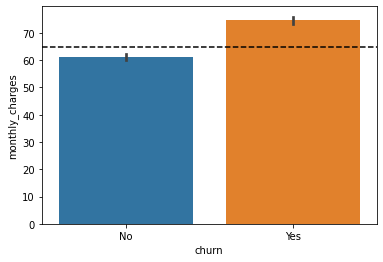

In [33]:
sns.barplot('churn', 'monthly_charges', data=telco_train)
plt.axhline(telco_train.monthly_charges.mean(), ls = '--', color = 'black')

<AxesSubplot:xlabel='churn_encoded', ylabel='monthly_charge_groups'>

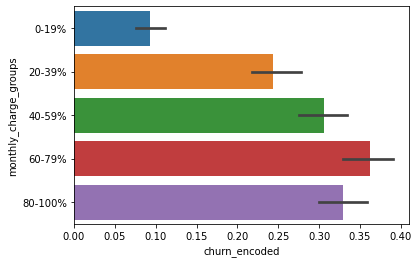

In [34]:
sns.barplot(x = 'churn_encoded', y ='monthly_charge_groups', data=telco_train)


Breaking down the monthly charges helps visulaize churn rates at thoughout the increasing intervals. We can see that churn steadily increases until the 20%. Athough the last group is lower than previous it is still the second highest. I will run a statistical test to determine whether or not this feature is statisitically significant.

In [35]:
monthly_group_stat = pd.crosstab(telco_train.monthly_charges, telco_train.churn_encoded)

print(monthly_group_stat)

a = 0.05

chi2, p, degf, expected = stats.chi2_contingency(monthly_group_stat)

chi2, p


if p < a:
    print("We reject the null hypothesis and this variable is statistically significant")
else:
    print("We fail to reject the null hypothesis and this feature is not statisitcally significant")

churn_encoded    0  1
monthly_charges      
18.25            1  0
18.40            1  0
18.55            1  0
18.75            1  0
18.80            2  0
...             .. ..
117.60           1  0
118.20           1  0
118.35           0  1
118.60           2  0
118.65           1  0

[1388 rows x 2 columns]
We reject the null hypothesis and this variable is statistically significant


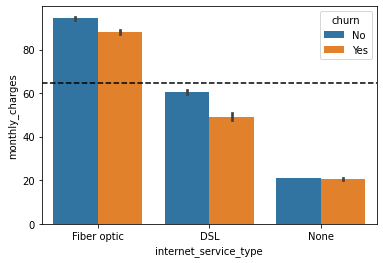

In [27]:
sns.barplot('internet_service_type', 'monthly_charges', hue =  'churn', data=telco_train)
plt.axhline(telco_train.monthly_charges.mean(), ls = '--', color = 'black')

We can see that fiber optic customer account for the majority of service types and has a high churn rate. Next I will test to see if service type is statistically significant when comparing to churn

In [28]:
internet_service_stat = pd.crosstab(telco_train.internet_service_type, telco_train.churn_encoded)

print(internet_service_stat)

a = 0.05

chi2, p, degf, expected = stats.chi2_contingency(internet_service_stat)

chi2, p


if p < a:
    print("We reject the null hypothesis and this variable is statistically significant")
else:
    print("We fail to reject the null hypothesis and this feature is not statisitcally significant")

churn_encoded             0    1
internet_service_type           
DSL                    1254  286
Fiber optic            1135  837
None                    915   73
We reject the null hypothesis and this variable is statistically significant


The test conclude that internet service type is a statistically signifcant variable and churning is not randomly happening by chance. 

<AxesSubplot:xlabel='churn', ylabel='security_bundle'>

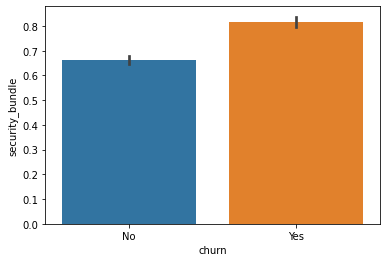

In [38]:
sns.barplot(x = 'churn', y ='security_bundle', data=telco_train)


In [39]:
security_stat = pd.crosstab(telco_train.security_bundle, telco_train.churn_encoded)

print(security_stat)

a = 0.05

chi2, p, degf, expected = stats.chi2_contingency(security_stat)

chi2, p


if p < a:
    print("We reject the null hypothesis and this variable is statistically significant")
else:
    print("We fail to reject the null hypothesis and this feature is not statisitcally significant")

churn_encoded       0    1
security_bundle           
0                1119  219
1                2185  977
We reject the null hypothesis and this variable is statistically significant


In [37]:
telco_train.streaming_fiber.value_counts(), telco_train.security_suite_fiber.value_counts()

(0    2764
 1    1736
 Name: streaming_fiber, dtype: int64,
 1    2284
 0    2216
 Name: security_suite_fiber, dtype: int64)

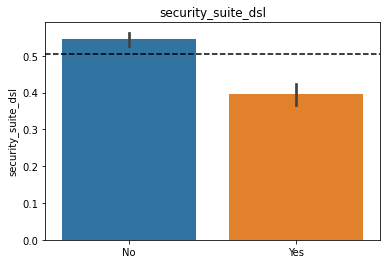

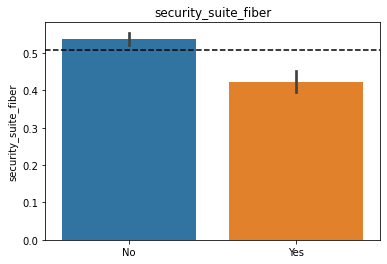

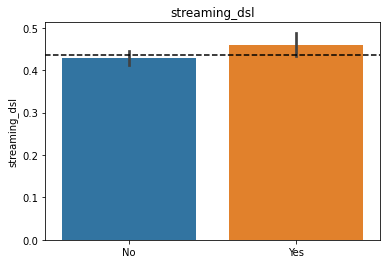

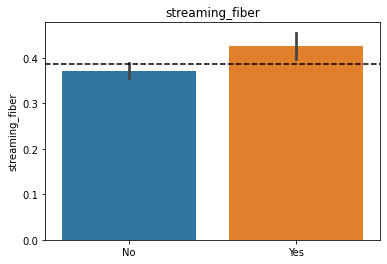

In [15]:
variables = ['security_suite_dsl','security_suite_fiber','streaming_dsl', 'streaming_fiber']

mean = [telco_train['security_suite_dsl'].mean(), telco_train['security_suite_fiber'].mean(), telco_train['streaming_dsl'].mean(), telco_train['streaming_fiber'].mean()]

for x in range(0,4):
    sns.barplot('churn',variables[x], data=telco_train)
    
    plt.xlabel('')
    plt.title(variables[x])
    plt.axhline(mean[x], ls = '--', color = 'black')
    plt.show()

This is interesting. I would expect fiber users with faster internet to enjoy streaming more and essentailly churn less. However, it appears that streaming bundles churn more for both internet types. Security features seem to be keep customers from churning. This is the overall picture and I want to explore if contract type makes any difference in churn rates.

In [16]:
streaming_fiber_stat = pd.crosstab(telco_train.streaming_fiber, telco_train.churn_encoded)

print(streaming_fiber_stat)

a = 0.05

chi2, p, degf, expected = stats.chi2_contingency(streaming_fiber_stat)

chi2, p


if p < a:
    print("We reject the null hypothesis and this variable is statistically significant")
else:
    print("We fail to reject the null hypothesis and this feature is not statisitcally significant")

churn_encoded       0    1
streaming_fiber           
0                2077  687
1                1227  509
We reject the null hypothesis and this variable is statistically significant


In [17]:
security_fiber_stat = pd.crosstab(telco_train.security_suite_fiber, telco_train.churn_encoded)

print(security_fiber_stat)

a = 0.05

chi2, p, degf, expected = stats.chi2_contingency(security_fiber_stat)

chi2, p


if p < a:
    print("We reject the null hypothesis and this feature is statistically significant")
else:
    print("We fail to reject the null hypothesis and this feature is not statistically significant")

churn_encoded            0    1
security_suite_fiber           
0                     1525  691
1                     1779  505
We reject the null hypothesis and this feature is statistically significant


In [18]:
security_dsl_stat = pd.crosstab(telco_train.security_suite_dsl, telco_train.churn_encoded)

print(security_dsl_stat)

a = 0.05

chi2, p, degf, expected = stats.chi2_contingency(security_dsl_stat)

chi2, p


if p < a:
    print("We reject the null hypothesis and this feature is statistically significant")
else:
    print("We fail to reject the null hypothesis and this feature is not statistically significant")

churn_encoded          0    1
security_suite_dsl           
0                   1504  723
1                   1800  473
We reject the null hypothesis and this feature is statistically significant


In [19]:
streaming_dsl_stat = pd.crosstab(telco_train.streaming_dsl, telco_train.churn_encoded)

print(streaming_dsl_stat)

a = 0.05

chi2, p, degf, expected = stats.chi2_contingency(streaming_dsl_stat)

chi2, p


if p < a:
    print("We reject the null hypothesis and this variable is statistically significant")
else:
    print("We fail to reject the null hypothesis and this feature is not statisitcally significant")

churn_encoded     0    1
streaming_dsl           
0              1889  647
1              1415  549
We fail to reject the null hypothesis and this feature is not statisitcally significant


<AxesSubplot:xlabel='churn_encoded', ylabel='monthly_charge_groups'>

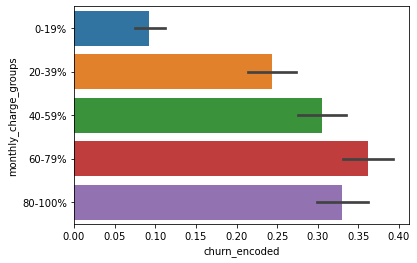

In [20]:
sns.barplot(x = 'churn_encoded', y ='monthly_charge_groups', data=telco_train)



In [21]:
telco_train.groupby('monthly_charge_groups').monthly_charges.mean()

monthly_charge_groups
0-19%       20.726562
20-39%      44.137065
40-59%      69.818901
60-79%      86.168274
80-100%    103.067181
Name: monthly_charges, dtype: float64

I broke down the monthly charges into bins to determine if after a certain threshold customers were more likely to churn. The first jump after 20% shows a significant change in churn. However, they start to follow closer to a normal distribution. What is the underlying cause of the higher monthly charges?

<AxesSubplot:xlabel='churn', ylabel='Bundled'>

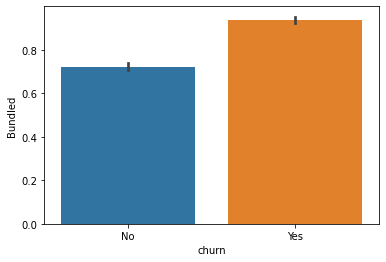

In [42]:
sns.barplot(x = 'churn', y ='Bundled', data=telco_train)

<AxesSubplot:xlabel='Bundled', ylabel='tenure'>

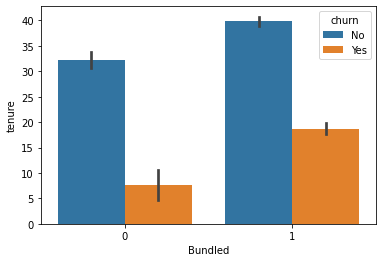

In [43]:
sns.barplot('Bundled', 'tenure', hue =  'churn', data=telco_train)

In [44]:
bundled_stat = pd.crosstab(telco_train.Bundled, telco_train.churn_encoded)

print(bundled_stat)

a = 0.05

chi2, p, degf, expected = stats.chi2_contingency(bundled_stat)

chi2, p


if p < a:
    print("We reject the null hypothesis and this variable is statistically significant")
else:
    print("We fail to reject the null hypothesis and this feature is not statisitcally significant")

churn_encoded     0     1
Bundled                  
0               915    73
1              2389  1123
We reject the null hypothesis and this variable is statistically significant


<AxesSubplot:xlabel='churn', ylabel='security_bundle'>

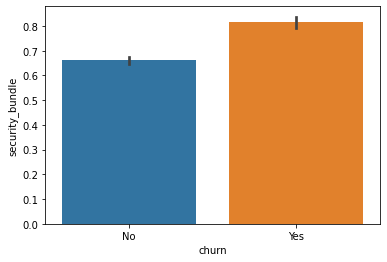

In [24]:
sns.barplot(x = 'churn', y ='security_bundle', data=telco_train)

In [25]:
security_bundle_stat = pd.crosstab(telco_train.security_bundle, telco_train.churn_encoded)

print(security_bundle_stat)

a = 0.05

chi2, p, degf, expected = stats.chi2_contingency(security_bundle_stat)

chi2, p


if p < a:
    print("We reject the null hypothesis and this variable is statistically significant")
else:
    print("We fail to reject the null hypothesis and this feature is not statisitcally significant")

churn_encoded       0    1
security_bundle           
0                1119  219
1                2185  977
We reject the null hypothesis and this variable is statistically significant


<AxesSubplot:xlabel='churn', ylabel='streaming_bundle'>

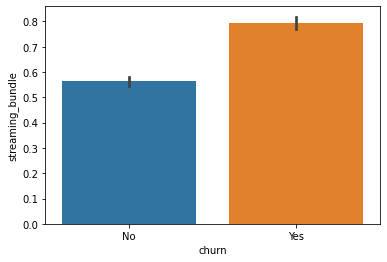

In [40]:
sns.barplot(x = 'churn', y ='streaming_bundle', data=telco_train)

In [41]:
streaming_bundle_stat = pd.crosstab(telco_train.streaming_bundle, telco_train.churn_encoded)

print(streaming_bundle_stat)

a = 0.05

chi2, p, degf, expected = stats.chi2_contingency(streaming_bundle_stat)

chi2, p


if p < a:
    print("We reject the null hypothesis and this variable is statistically significant")
else:
    print("We fail to reject the null hypothesis and this feature is not statisitcally significant")

churn_encoded        0    1
streaming_bundle           
0                 1445  245
1                 1859  951
We reject the null hypothesis and this variable is statistically significant


In [ ]:
telco_train.groupby('total_charge_groups').monthly_charges.mean()

total_charge_groups
0-10%       41.109677
10-20%      50.616381
20-30%      47.901345
30-40%      50.685287
40-50%      50.218519
50-60%      57.549425
60-70%      74.992670
70-80%      80.237912
80-90%      90.004656
90-100%    102.836652
Name: monthly_charges, dtype: float64

In [ ]:
telco_train.groupby('tenure').monthly_charges.mean()

tenure
1     50.116789
2     58.633548
3     56.622426
4     54.373967
5     56.551899
6     55.036765
7     61.818675
8     59.706410
9     63.274627
10    56.362805
11    61.957407
12    56.452027
13    63.773239
14    60.240698
15    57.589062
16    58.001961
17    68.457143
18    59.683036
19    58.506522
20    59.881250
21    67.973684
22    58.855556
23    62.333654
24    61.250909
25    60.317021
26    63.792453
27    62.452083
28    66.555556
29    63.667442
30    69.905435
31    69.731395
32    73.743617
33    64.814474
34    67.896939
35    61.525000
36    64.667308
37    67.417857
38    69.097368
39    55.704286
40    70.723256
41    63.787500
42    65.234444
43    68.162162
44    64.662857
45    77.691667
46    65.982653
47    69.810870
48    67.350000
49    74.134615
50    75.022500
51    66.330556
52    67.371930
53    67.700893
54    73.245122
55    63.942045
56    71.966667
57    69.462500
58    68.812500
59    77.458824
60    74.506818
61    75.165217
62    70.707143
6

Looking at the groupby tenure against monthly charges it looks that monthly charges are positively correlated as tenure rises so do monthly payments. I think a part of this is beacuse people add on services. I want to break down how Telco services affect churn rate. 

<AxesSubplot:xlabel='churn_encoded', ylabel='tenure'>

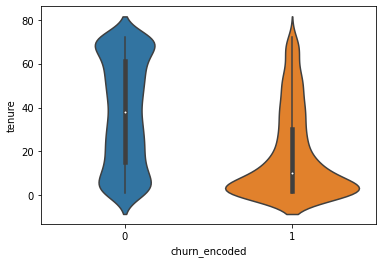

In [ ]:
sns.violinplot(x = 'churn_encoded', y ='tenure', data=telco_train)

The two graphs above are showing that churn happens with the lowest 10th% are inclined to churn more and more churn happens early in tenure compared to after. I will apply a bundle condtion to one year and two year contract to see if there is any significance.

In [ ]:
telco_train.groupby('tenure').monthly_charges.mean().describe()

count    72.000000
mean     66.247089
std       6.888483
min      50.116789
25%      61.017437
50%      66.443056
75%      71.451715
max      79.248298
Name: monthly_charges, dtype: float64

Looking at the describe data, it does not show much a of a deviation as time goes on. Perhaps it looks worse when looking at lowest tenure monthly charge mean against the highest tenure monthly mean. However the differnce is not as great as originally thought. 

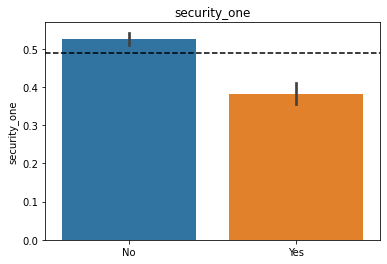

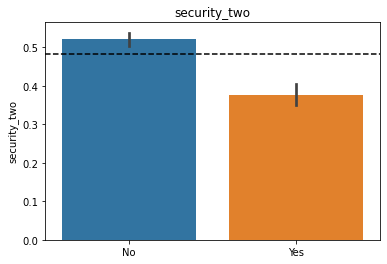

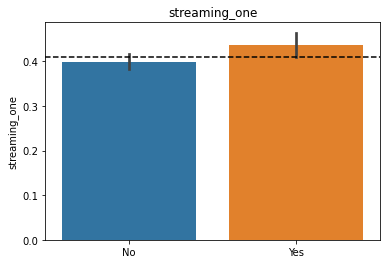

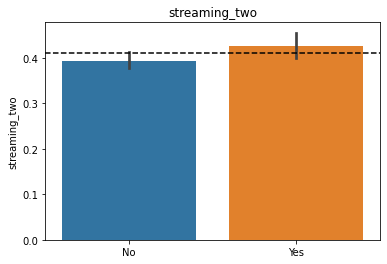

In [ ]:
variables2 = ['security_one','security_two','streaming_one', 'streaming_two']

mean2 = [telco_train['security_one'].mean(), telco_train['security_two'].mean(), telco_train['streaming_one'].mean(), telco_train['streaming_one'].mean()]

for x in range(0,4):
    sns.barplot('churn',variables2[x], data=telco_train)
    
    plt.xlabel('')
    plt.title(variables2[x])
    plt.axhline(mean2[x], ls = '--', color = 'black')
    plt.show()

From my previous charts it shows that having security services bundled with internet churn less than streaming bundled customers. Despite a higher montly charge due to additional services the security customers churn less. 

<AxesSubplot:xlabel='Bundled', ylabel='tenure'>

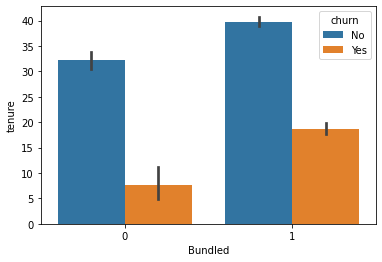

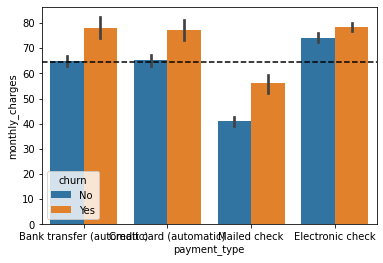

In [ ]:
sns.barplot('payment_type', 'monthly_charges', hue =  'churn', data=telco_train)
plt.axhline(telco_train.monthly_charges.mean(), ls = '--', color = 'black')

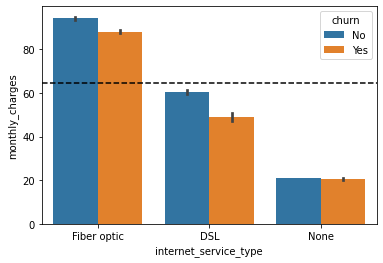

In [ ]:
sns.barplot('internet_service_type', 'monthly_charges', hue =  'churn', data=telco_train)
plt.axhline(telco_train.monthly_charges.mean(), ls = '--', color = 'black')

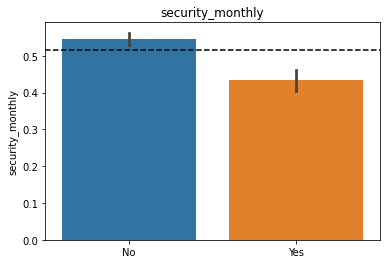

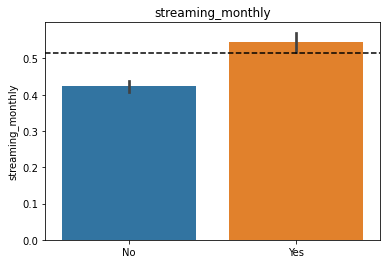

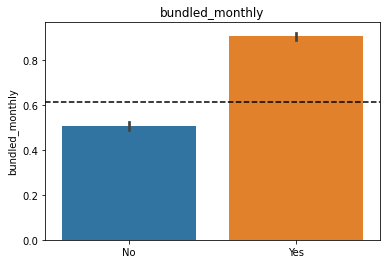

In [ ]:
variables3 = ['security_monthly','streaming_monthly', 'bundled_monthly']

mean3 = [telco_train['security_monthly'].mean(), telco_train['security_monthly'].mean(), telco_train['bundled_monthly'].mean()]

for x in range(0,3):
    sns.barplot('churn',variables3[x], data=telco_train)
    
    plt.xlabel('')
    plt.title(variables3[x])
    plt.axhline(mean3[x], ls = '--', color = 'black')
    plt.show()

After breaking down month to month customers by bundles and service types, the trends continue. We can see that security services continue to encourage retention while streaming is the opposite. 

In [ ]:
telco_train.groupby('bundled_monthly').monthly_charges.mean()

bundled_monthly
0    40.659439
1    80.010901
Name: monthly_charges, dtype: float64

In [ ]:
telco_train.groupby('streaming_monthly').monthly_charges.mean()

streaming_monthly
0    46.022426
1    87.036940
Name: monthly_charges, dtype: float64

In [ ]:
telco_train.groupby('security_monthly').monthly_charges.mean()

security_monthly
0    48.765987
1    79.761135
Name: monthly_charges, dtype: float64

Bundled monthly is churning more than streaming and security. The average monthly pay for these customers is less than streaming and almost the same for 

In [ ]:
telco_train.groupby('streaming_dsl').monthly_charges.mean()

streaming_dsl
0    48.522220
1    85.646818
Name: monthly_charges, dtype: float64

In [ ]:
telco_train.groupby('streaming_fiber').monthly_charges.mean()

streaming_fiber
0    49.483973
1    88.991359
Name: monthly_charges, dtype: float64

In [ ]:
telco_train.groupby('security_suite_dsl').monthly_charges.mean()

security_suite_dsl
0    50.492366
1    78.669688
Name: monthly_charges, dtype: float64

In [ ]:
telco_train.groupby('security_suite_fiber').monthly_charges.mean()

security_suite_fiber
0    47.746593
1    81.198008
Name: monthly_charges, dtype: float64

In [ ]:
telco_train.groupby('Bundled').monthly_charges.mean()

Bundled
0    21.062702
1    77.008186
Name: monthly_charges, dtype: float64

The average monthly charges for customers with security services is 80 a month
The average monthly charges for customers with streaming services is 87.50 a month
the average monthly costs for customers with internet and phone is 77 a month 

In [ ]:
telco_train.groupby('only_fiber').monthly_charges.mean()

only_fiber
0    64.725044
Name: monthly_charges, dtype: float64

In [ ]:
telco_train.groupby('internet_service_type_Fiber optic').monthly_charges.mean()

internet_service_type_Fiber optic
0    43.701760
1    91.675786
Name: monthly_charges, dtype: float64

In [ ]:
telco_train.groupby('only_dsl').monthly_charges.mean()

only_dsl
0    67.160558
1    41.790625
Name: monthly_charges, dtype: float64

In [ ]:
security = [
    ('security_one', 'security_two'),
    ('security_monthly', 'security_suite_fiber'),
    ('securtiy_suite_dsl'), 
]

securtiy_mean = [telco_train['security_one'].mean(), telco_train['security_two'].mean(), telco_train['security_monthly'].mean(), telco_train['security_suite_fiber'].mean(), telco_train['security_suite_dsl'].mean()]


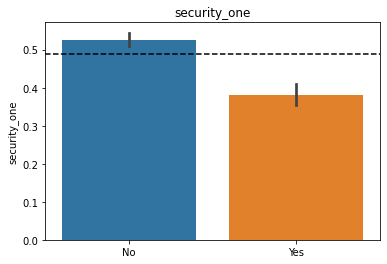

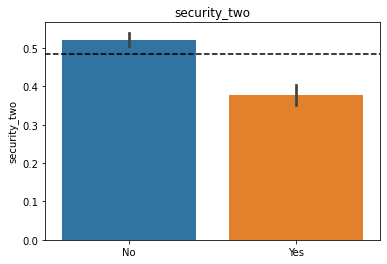

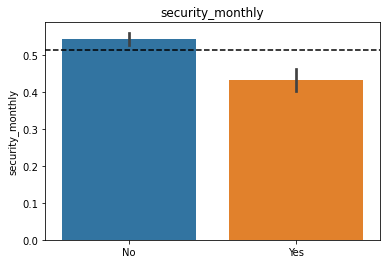

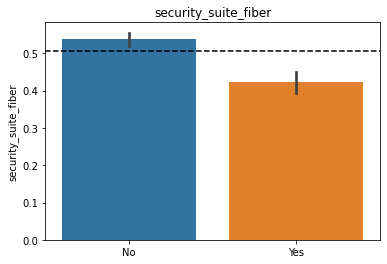

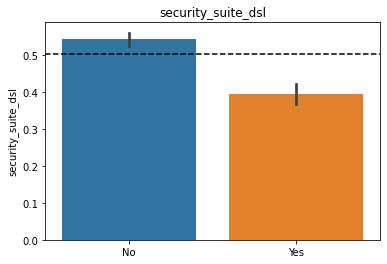

In [ ]:
security = ['security_one', 'security_two', 'security_monthly', 'security_suite_fiber', 'security_suite_dsl']

security_mean = [telco_train['security_one'].mean(), telco_train['security_two'].mean(), telco_train['security_monthly'].mean(), telco_train['security_suite_fiber'].mean(), telco_train['security_suite_dsl'].mean()]

# x_sec = security
# y_sec = 'churn'
#def security_bars():
for x in range(0,5):
        # fig, axes = plt.subplots(2, 2)
        sns.barplot('churn',security[x], data=telco_train)
        plt.xlabel('')
        plt.title(security[x])
        plt.axhline(security_mean[x], ls = '--', color = 'black')
        plt.show()

In [ ]:
h(1) = subplot(3,2,1);
h(2) = subplot(3,2,2);
h(3) = subplot(3,2,3);
h(4) = subplot(3,2,4);
h(5) = subplot(3,2,5); #% the last (odd) axes
pos = get(h,'Position');
new = mean(cellfun(@(v)v(1),pos(1:2)));
set(h(5),'Position',[new,pos{end}(2:end)])

SyntaxError: cannot assign to function call (2131320198.py, line 1)

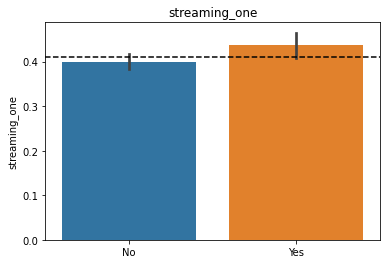

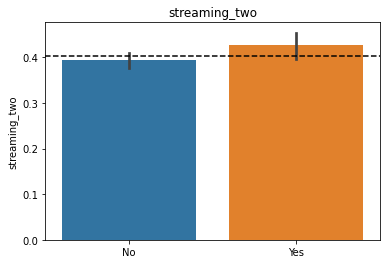

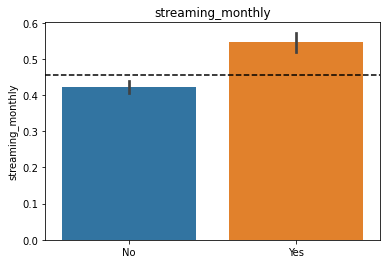

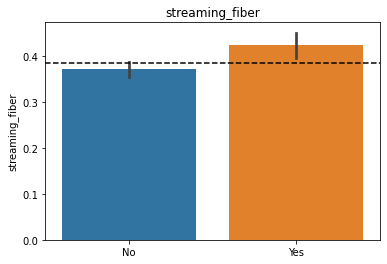

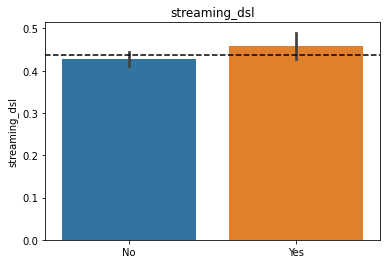

In [ ]:
streaming = ['streaming_one', 'streaming_two', 'streaming_monthly', 'streaming_fiber', 'streaming_dsl']

streaming_mean = [telco_train['streaming_one'].mean(), telco_train['streaming_two'].mean(), telco_train['streaming_monthly'].mean(), telco_train['streaming_fiber'].mean(), telco_train['streaming_dsl'].mean()]

# x_sec = security
# y_sec = 'churn'
#def security_bars():
for x in range(0,5):
        # fig, axes = plt.subplots(2, 2)
        sns.barplot('churn',streaming[x], data=telco_train)
        plt.xlabel('')
        plt.title(streaming[x])
        plt.axhline(streaming_mean[x], ls = '--', color = 'black')
        plt.show()

IndexError: index 2 is out of bounds for axis 1 with size 2

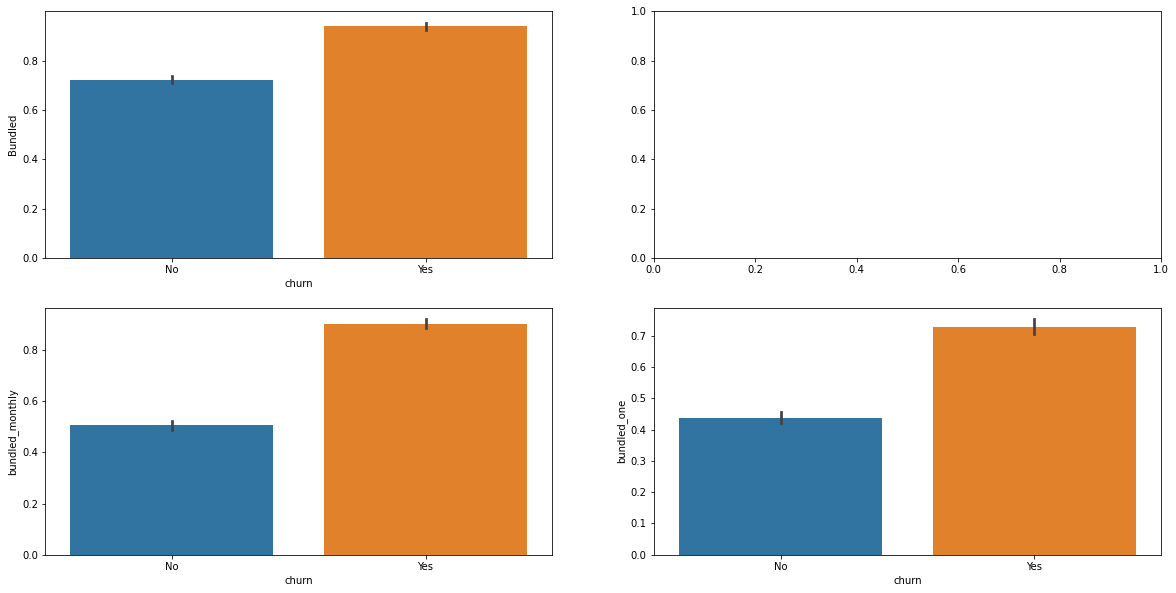

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20,10))

sns.barplot(x = 'churn', y = 'Bundled',data = telco_train, ax = axes[0, 0])
sns.barplot(x = 'churn', y = 'bundled_monthly',data = telco_train, ax = axes[1,0])
sns.barplot(x = 'churn', y = 'bundled_one',data = telco_train, ax = axes[1,1])
sns.barplot(x = 'churn', y = 'bundled_two',data = telco_train, ax = axes[1,2])
axes[0,0].set_title("All bundled customers")
axes[1,0].set_title("Month to Month bundled")
plt.suptitle("Telephone and Internet")


## Fiber doesn't have customers not bundled

time to move onto modeling and using the features that I selected from doing my EDA on the Telco Data available. 



The features I am selecting are from my previous exerpeince and through statistical testing, they are:
monthly_charges_group, contract_type_One year,  contract_type_Two year, Bundled, security_bundle, streaming_bundle

In [51]:
x_vars = ['monthly_charge_groups', 'contract_type_One year', 'contract_type_Two year', 'Bundled', 'security_bundle', 'streaming_bundle']
y_vars = 'churn_encoded'

X_train, y_train = telco_train[x_vars], telco_train[y_vars]
x_validate, y_validate = telco_validate[x_vars], telco_validate[y_vars]
x_test, y_test = telco_test[x_vars], telco_test[y_vars]

In [ ]:
metrics = []

for i in range(2, 25):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(x_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df